In [29]:
from typing import Dict, List, Tuple, Union, Optional, Callable

import sys
import wandb
import numpy as np
import math
import pandas as pd
import os
from copy import deepcopy
from argparse import Namespace
from pathlib import Path
import logging
import torch
from scipy import stats
from torch.optim import Adam
from torch.utils.data import DataLoader as DL_torch
from torch_geometric.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from functools import partial
# import pdb
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D

from abag_affinity.dataset import AffinityDataset
from abag_affinity.dataset.advanced_data_utils import complexes_from_dms_datasets, get_bucket_dataloader, load_datasets
from abag_affinity.model import AffinityGNN, TwinWrapper
from abag_affinity.train.wandb_config import configure
from abag_affinity.utils.config import get_data_paths, read_config
from abag_affinity.utils.visualize import plot_correlation
from abag_affinity.utils.argparse_utils import read_args_from_file, parse_args
from abag_affinity.train.utils import load_model
from abag_affinity.model import regression_heads
from abag_affinity.utils.pdb_processing import AMINO_ACIDS
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
args_file = "base_args.txt"

sys.argv = sys.argv[:1]
args = parse_args(args_file=args_file)

config = read_config(args.config_file)

args.batch_size = 1
args.cuda = False
use_cuda = False
device = 'cpu'

train_data, val_datas = load_datasets(config, args.target_dataset, args.validation_set, args)
# test_sets = ['AntibodyBenchmark', 'SKEMPI.v2', 'abag_affinity']
test_sets = ['AntibodyBenchmark']

# wandb_benchmark_log = run_and_log_benchmarks(model, args, wandb_inst)

In [4]:
def get_test_dataloader(test_set: str, args: Namespace) -> DataLoader:
    if test_set == "abag_affinity":
        summary_path, _ = get_data_paths(args.config, "abag_affinity")
        summary_df = pd.read_csv(summary_path, index_col=0)
        if args.validation_set is None:
            summary_df = summary_df[summary_df["test"]]
        elif args.validation_set < 0:
            summary_df = summary_df[summary_df["validation"] != ((-1 * args.validation_set) - 1)]
        else:
            summary_df = summary_df[summary_df["validation"] == args.validation_set]
        pdb_ids = summary_df.index.tolist()
    else:
        pdb_ids = None
    dataset = AffinityDataset(args.config, args.relaxed_pdbs, test_set, "L2",
                              pdb_ids=pdb_ids,
                              node_type=args.node_type,
                              max_nodes=args.max_num_nodes,
                              interface_distance_cutoff=args.interface_distance_cutoff,
                              interface_hull_size=args.interface_hull_size,
                              max_edge_distance=args.max_edge_distance,
                              pretrained_model=args.pretrained_model,
                              scale_values=args.scale_values,
                              scale_min=args.scale_min,
                              scale_max=args.scale_max,
                              relative_data=False,
                              save_graphs=args.save_graphs,
                              force_recomputation=args.force_recomputation,
                              preprocess_data=args.preprocess_graph,
                              preprocessed_to_scratch=args.preprocessed_to_scratch,
                              num_threads=args.num_workers,
                              load_embeddings=None if not args.embeddings_type else (args.embeddings_type, args.embeddings_path)
                              )

    dataloader = DL_torch(dataset, num_workers=args.num_workers, batch_size=1,
                          collate_fn=AffinityDataset.collate)

    return dataloader

In [5]:
def get_dataset_predictions(model, dataloader, device):
    y_data = []
    y_pred = []
    preds_per_residue = {}

    for data in dataloader:
        data_copy = deepcopy(data)
        # print('data', data)
        # print('data input size', data['input']['graph']['node'].x.shape)
        # output = model(data['input'])
        #
        # print(output)
        y_data.append(data_copy['input']['graph']['-log(Kd)'].item())
        out = model(data_copy['input'])
        y_pred.append(out['-log(Kd)'].item())

        res_types = np.where(data['input']['graph']['node'].x[:, :20] == 1)[1]
        # with np.printoptions(threshold=np.inf):
        #     print('data graph', data['input']['graph']['node'].x.numpy())

        out2 = model.graph_conv(data['input']['graph'])

        x = out2["node"].x

        batch = regression_heads.get_node_batches(out2).to(x.device)

        if model.regression_head.aggregation_method in ["interface_sum", "interface_mean", "interface_size"]:
            # get interface edges
            interface_node_indices = out2["node", "interface", "node"].edge_index.view(-1).unique()
            batch = batch[interface_node_indices]
            x = x[interface_node_indices]
            res = res_types[interface_node_indices]
        # compute node-wise affinity contribution from graph embedding
        for fc_layer in model.regression_head.fc_layers[:-1]:
            x = fc_layer(x)
            x = model.regression_head.activation(x)
        x = model.regression_head.fc_layers[-1](x)
        for i in range(res.shape[0]):
            if res[i] in preds_per_residue.keys():
                preds_per_residue[res[i].item()].append(x[i].item())
            else:
                preds_per_residue[res[i].item()] = [x[i].item()]
    y_data = np.array(y_data)
    y_pred = np.array(y_pred)

    return preds_per_residue, y_data, y_pred

In [6]:
model = AffinityGNN.load_from_checkpoint('/home/mihail/Documents/workspace/ag_binding_affinity/results/models/2023-12-20_19-00-38_fix_labels_abag_test/model.pt',
                                         map_location='cpu')
model.to('cpu')
train_dataloader, val_dataloaders = get_bucket_dataloader(args, [train_data], val_datas)
test_dataloaders = {test_set: get_test_dataloader(test_set, args) for test_set in test_sets}

In [7]:
dataloaders = {'Training': train_dataloader}
dataloaders.update({'Validation' + str(i): val_dataloaders[i] for i in range(len(val_dataloaders))})
dataloaders.update(test_dataloaders)

In [8]:
results = {}
for set_name, dataloader in dataloaders.items():
    results[set_name] = {}
    print('Per residue results for ' + set_name + ' dataset')
    preds_per_residue, y_data, y_pred = get_dataset_predictions(model, dataloader, device)
    results[set_name]['preds_per_residue'] = preds_per_residue
    results[set_name]['y_data'] = y_data
    results[set_name]['y_pred'] = y_pred

    means_per_residue = {i: np.mean(preds_per_residue[i]) for i in preds_per_residue.keys()}
    stds_per_residue = {i: np.std(preds_per_residue[i]) for i in preds_per_residue.keys()}
    results[set_name]['average_residue_scores'] = means_per_residue
    results[set_name]['standard_dev_per_residue'] = stds_per_residue

    print('average_residue_scores', means_per_residue, '\n')
    print('standard dev per residue', stds_per_residue, '\n')
    print('standard dev across residues', np.std(list(means_per_residue.values())), '\n')
    print('\n\n')

Per residue results for Training dataset
average_residue_scores {17: 0.011726194668723188, 9: 0.0124819566861042, 18: 0.012113928873564156, 3: 0.01165766550982294, 1: 0.011942671090935383, 10: 0.010711523841639033, 15: 0.00770779219886805, 7: 0.0005000357357960827, 0: 0.006464829072171346, 2: 0.003934089707710394, 6: 0.011648642151160146, 11: 0.011569175101983045, 5: 0.01030030148842978, 19: 0.010337830510702027, 8: 0.012600864674965245, 13: 0.012211878732411576, 16: 0.00898664374913659, 12: 0.012431729584932327, 4: 0.008358863152955708, 14: 0.010311691487421755} 

standard dev per residue {17: 0.002580344781276422, 9: 0.00506111723675758, 18: 0.004495882606226215, 3: 0.007942211970434057, 1: 0.006465767111056731, 10: 0.00947383488956815, 15: 0.011722457147185422, 7: 0.016641159587417926, 0: 0.013104958287461003, 2: 0.015577367353685818, 6: 0.007164931421099245, 11: 0.007870973435335703, 5: 0.009380145136344319, 19: 0.009251854293922715, 8: 0.0043868171659347316, 13: 0.0051289488838589

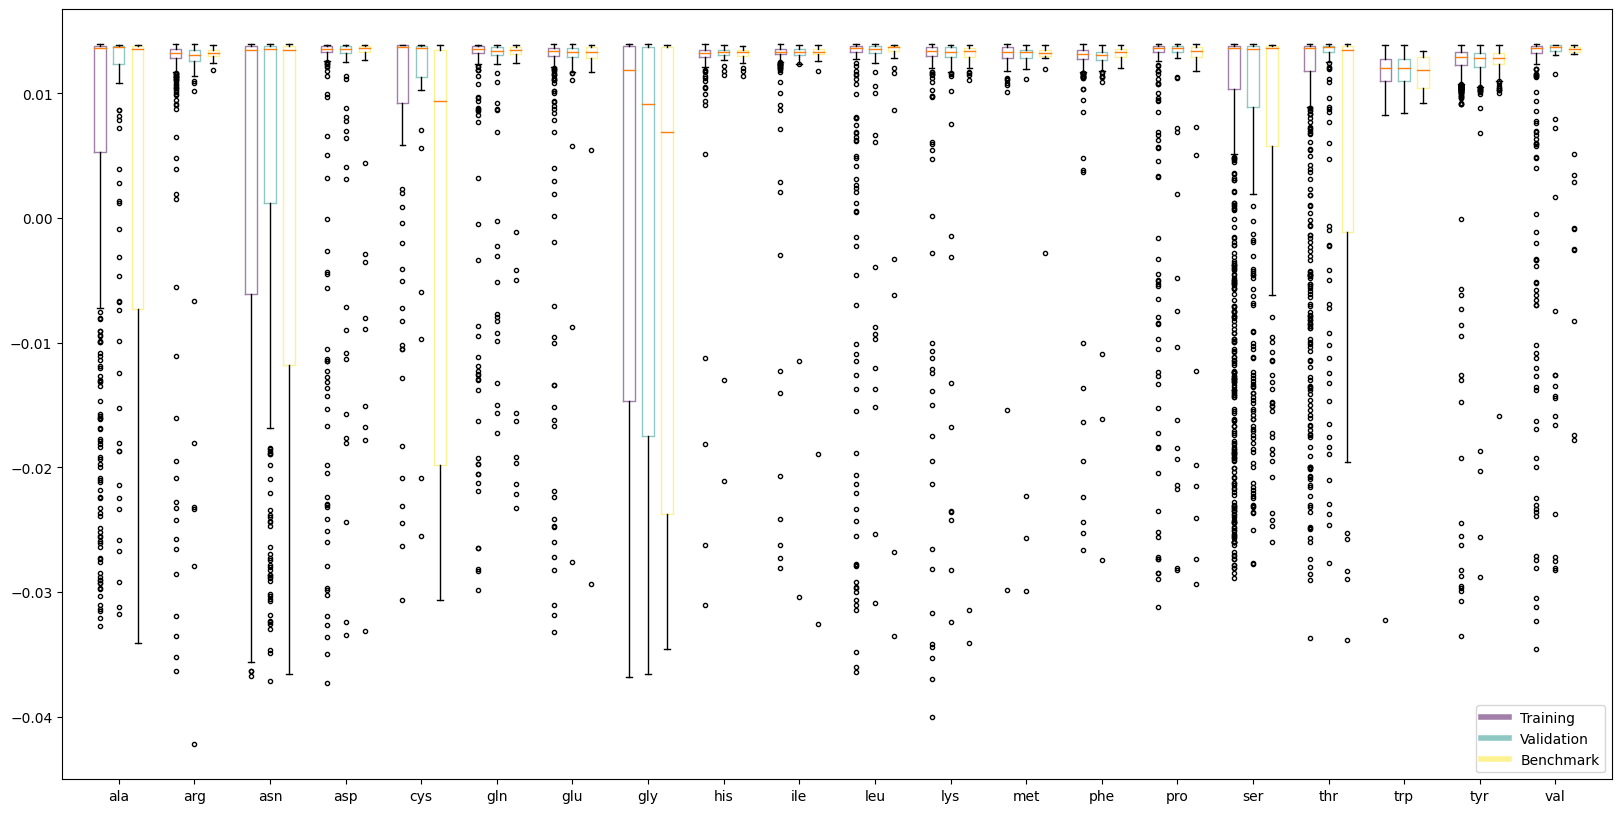

In [35]:
# Plot residue energy distributions


fig = plt.figure(figsize=(20, 10))
cmap_inds = np.linspace(0.0, 1.0, 3)
colors = colormaps['viridis'](cmap_inds)


offsets = np.linspace(-0.25, 0.25, len(results.keys()))
for i, set_name in enumerate(results.keys()):
    for res in results[set_name]['preds_per_residue'].keys():
        res_preds = results[set_name]['preds_per_residue'][res]
        plt.boxplot(res_preds, positions=[res + offsets[i]], boxprops=dict(color=colors[i], alpha=0.5), flierprops=dict(marker='.'))


custom_lines = [Line2D([0], [0], color=colors[0], lw=4, alpha=0.5),
                Line2D([0], [0], color=colors[1], lw=4, alpha=0.5),
                Line2D([0], [0], color=colors[2], lw=4, alpha=0.5)]

plt.legend(custom_lines, ['Training', 'Validation', 'Benchmark'], loc='lower right')
plt.xticks(list(results['Training']['preds_per_residue'].keys()), [AMINO_ACIDS[i] for i in results['Training']['preds_per_residue'].keys()])
plt.show()

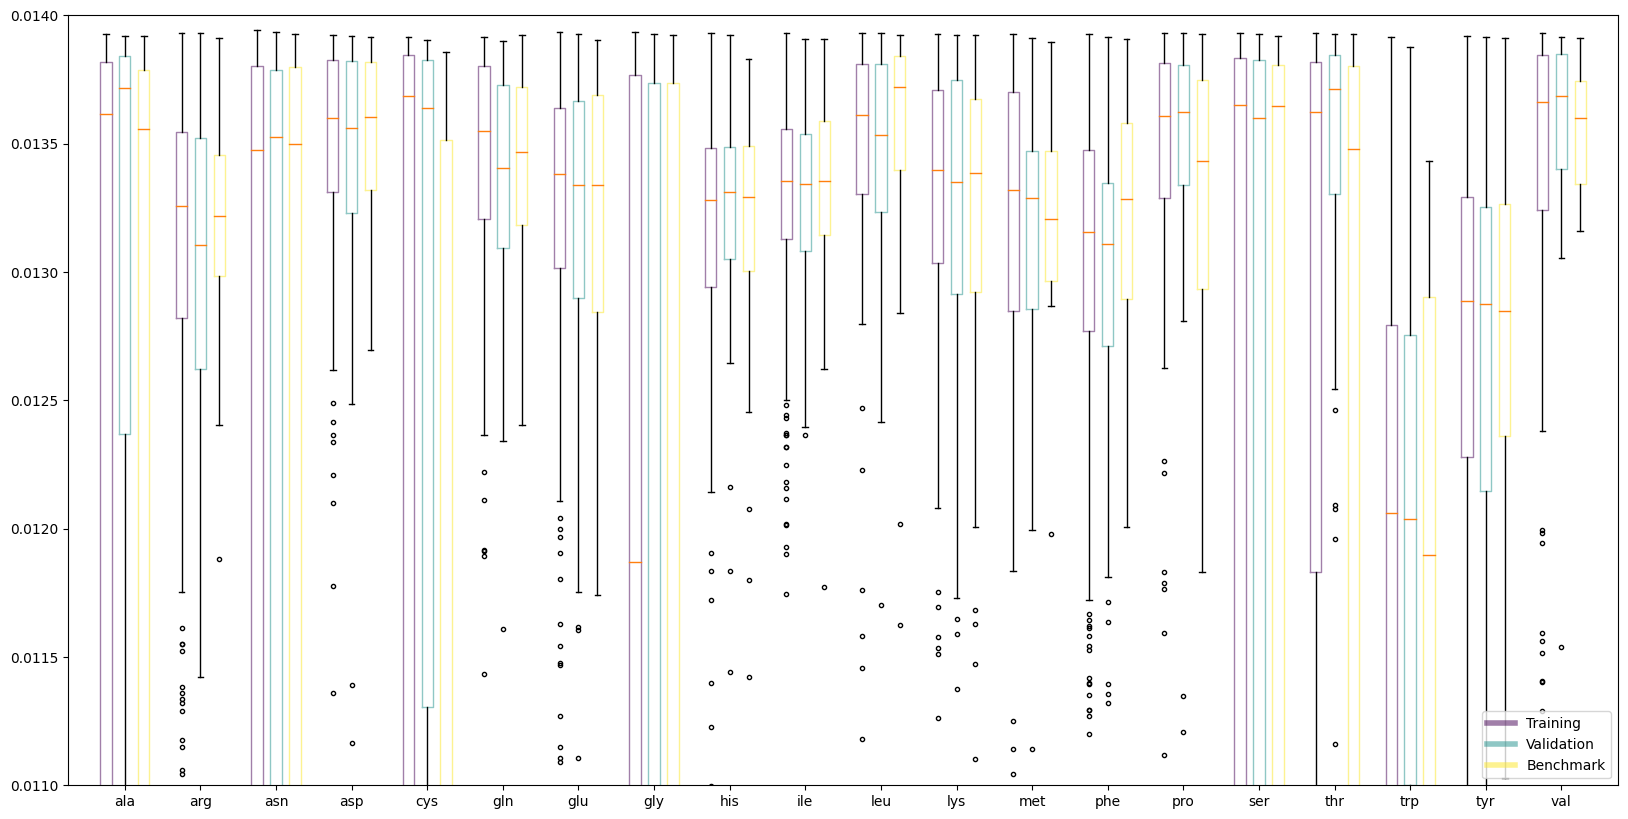

In [38]:
# Plot residue energy distributions


fig = plt.figure(figsize=(20, 10))
cmap_inds = np.linspace(0.0, 1.0, 3)
colors = colormaps['viridis'](cmap_inds)


offsets = np.linspace(-0.25, 0.25, len(results.keys()))
for i, set_name in enumerate(results.keys()):
    for res in results[set_name]['preds_per_residue'].keys():
        res_preds = results[set_name]['preds_per_residue'][res]
        plt.boxplot(res_preds, positions=[res + offsets[i]], boxprops=dict(color=colors[i], alpha=0.5), flierprops=dict(marker='.'))


custom_lines = [Line2D([0], [0], color=colors[0], lw=4, alpha=0.5),
                Line2D([0], [0], color=colors[1], lw=4, alpha=0.5),
                Line2D([0], [0], color=colors[2], lw=4, alpha=0.5)]

plt.legend(custom_lines, ['Training', 'Validation', 'Benchmark'], loc='lower right')
plt.xticks(list(results['Training']['preds_per_residue'].keys()), [AMINO_ACIDS[i] for i in results['Training']['preds_per_residue'].keys()])
plt.ylim(0.011, 0.014)
plt.show()

In [40]:
train_mean = np.mean(results['Training']['y_data'])

for set_name in dataloaders.keys():
    print(set_name, 'dataset')
    results[set_name]['train_mean_rmse'] = np.sqrt(np.mean((results[set_name]['y_data'] - train_mean) ** 2))
    results[set_name]['pred_rmse'] = np.sqrt(np.mean((results[set_name]['y_pred'] - results[set_name]['y_data']) ** 2))
    print('train_mean_rmse', results[set_name]['train_mean_rmse'])
    print('pred_rmse', results[set_name]['pred_rmse'])
    print("")

Training dataset
train_mean_rmse 0.16213827280404855
pred_rmse 0.1155047127776308

Validation0 dataset
train_mean_rmse 0.16570292877263126
pred_rmse 0.16149641672163967

AntibodyBenchmark dataset
train_mean_rmse 0.1620403425991364
pred_rmse 0.1660761818237867



In [41]:
mean_rmses = [results[set_name]['train_mean_rmse'] for set_name in dataloaders.keys()]
pred_rmses = [results[set_name]['pred_rmse'] for set_name in dataloaders.keys()]
np.corrcoef(mean_rmses, pred_rmses)
print('Correlation between train_mean_rmse and pred_rmse', np.corrcoef(mean_rmses, pred_rmses)[0, 1])

Correlation between train_mean_rmse and pred_rmse 0.40608923943051206


([<matplotlib.axis.XTick at 0x7f615942db20>,
 [Text(0, 0, 'Training'), Text(1, 0, 'Validation'), Text(2, 0, 'Benchmark')])

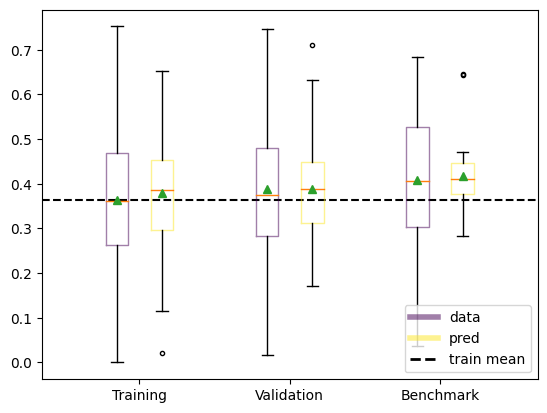

In [46]:
fig = plt.figure()

plt.axhline(y=train_mean, color='k', linestyle='--', label=f'Mean: {train_mean:.2f}')

offsets = np.linspace(-0.15, 0.15, 2)
cmap_inds = np.linspace(0.0, 1.0, 2)
colors = colormaps['viridis'](cmap_inds)
for i, set_name in enumerate(results.keys()):
    plt.boxplot(results[set_name]['y_data'], positions=[i + offsets[0]], boxprops=dict(color=colors[0], alpha=0.5),
                flierprops=dict(marker='.'), showmeans=True)
    plt.boxplot(results[set_name]['y_pred'], positions=[i + offsets[1]], boxprops=dict(color=colors[1], alpha=0.5),
                flierprops=dict(marker='.'), showmeans=True)

custom_lines = [Line2D([0], [0], color=colors[0], lw=4, alpha=0.5),
                Line2D([0], [0], color=colors[1], lw=4, alpha=0.5),
                Line2D([0], [0], color='k', lw=1.5, linestyle='--')]

plt.legend(custom_lines, ['data', 'pred', 'train mean'], loc='lower right')
plt.xticks([0, 1, 2], ['Training', 'Validation', 'Benchmark'])